In [2]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.utils_candidate_matches import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *
import pickle

In [3]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Annotations in the same folder as the .btf
external_annotations = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\masks-500.pickle'
external_annotations = os.path.join(bigtiff_folder, external_annotations)

# First, only subsequent matches

In [73]:
opt = {'start_frame':50,
       'num_frames':500,
       'verbose':0,
       'num_slices':33,
       #'num_subsequent_matches':1,
       'save_candidate_matches':False,
       'add_affine_to_candidates':False,
       'add_gp_to_candidates':False,
       'external_detections':external_annotations}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
# out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_conf, all_frames, candidates = out

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [47:08<00:00,  5.67s/it]


In [102]:
# Force a restart at 0; the video later will have to start at the same point
list_frames = list(all_frames.values())
offset = opt['start_frame']
reindexed_matches = {(k[0]-offset,k[1]-offset):v for k,v in all_matches.items()}
clust_df = build_tracklets_from_classes(list_frames, reindexed_matches, verbose=0)

In [103]:
suffix = 'sequential-stardist'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(all_matches, f)
fname = f'frame_dat_{suffix}.pickle'

[frame.prep_for_pickle() for frame in all_frames.values()]
with open(fname, 'wb') as f:
    pickle.dump(all_frames, f)

## Visualize

0        66
1        60
2       500
3       257
4       256
       ... 
6499      2
6500      2
6501      2
6502      2
6503      2
Name: slice_ind, Length: 6504, dtype: int64

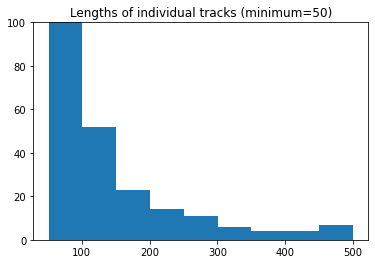

In [104]:
hist_of_tracklet_lens(clust_df)

In [79]:
k = (51,52)
plot_matched_point_clouds(all_frames, all_matches, k);

# Step 2: window consensus

In [58]:
# opt = {'start_frame':50,
#        'num_frames':490,
#        'verbose':0,
#        'num_slices':33,
#        'num_subsequent_matches':7,
#        'save_candidate_matches':True,
#        'add_affine_to_candidates':True,
#        'add_gp_to_candidates':True,
#        'external_detections':external_annotations}

# p = PreprocessingSettings()
# p.do_filtering=False
# p.do_rigid_alignment=True
# p.do_mini_max_projection=True

# out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
# all_matches, all_conf, all_frames, candidates = out

In [ ]:
all_communities = calc_neurons_using_k_cliques(candidates,
                                 k_values = [6,5,4,3],
                                 list_min_sizes = [450, 400],
                                 max_size = 500)

In [ ]:
clique_matches = community_to_matches(all_communities)
# Force a restart at 0; the video later will have to start at the same point
list_frames = list(all_frames.values())
clust_df = build_tracklets_from_classes(list_frames, dict(clique_matches), verbose=0)

In [ ]:
suffix = 'sequential-7-stardist'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clique_matches, f)
fname = f'frame_dat_{suffix}.pickle'
[frame.prep_for_pickle() for frame in list_frames]
with open(fname, 'wb') as f:
    pickle.dump(list_frames, f)

# Step 3: Reference frame pipeline

In [3]:
opt = {'start_frame':50,
       'num_frames':6,
       'num_reference_frames':5,
       'num_slices':33,
       'use_affine_matching':True,
#        'add_gp_to_candidates':False,
#        'add_affine_to_candidates':False,
#        'use_affine_matching':False,
       'neuron_cluster_mode':'voronoi',
       'external_detections':external_annotations}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_via_reference_frames(btf_fname_red, **opt)
all_matches, all_other_frames, reference_set = out

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


In [ ]:
# # Fix bug above
# for m, f, in zip(all_matches, all_other_frames):
#     f.neuron_ids = m

In [35]:
# Cast these matches into dataframe format
# Force reset at 0
columns=['clust_ind', 'all_ind_local', 'all_ind_global', 'all_xyz',
             'all_prob',
             'slice_ind','extended_this_slice', 'not_finished']

from collections import defaultdict
all_all_ind_local = defaultdict(list)
all_all_xyz = defaultdict(list)
all_all_slice_ind = defaultdict(list)
# Do reference frames and other frames
all_frames = list(reference_set.reference_frames.values())
all_frames.extend(all_other_frames)
for f in all_frames:
#     Add all neurons to each cluster, if present
    for i in range(len(f.neuron_ids)):
        clust_ind = f.neuron_ids[i][1] # Global ID
        i_local = f.neuron_ids[i][0]
        all_all_ind_local[clust_ind].append(i_local)
        all_all_xyz[clust_ind].append(f.neuron_locs[i_local])
        all_all_slice_ind[clust_ind].append(f.frame_ind)

# Format to be made into a dataframe
offset = 50
big_dict = {'clust_ind':[],'all_ind_local':[],'all_xyz':[],'slice_ind':[],'all_prob':[]}
for i,k in enumerate(all_all_ind_local.keys()):
    big_dict['clust_ind'].append(k)
    big_dict['all_ind_local'].append(all_all_ind_local[k])
    big_dict['all_xyz'].append(all_all_xyz[k])
    big_dict['slice_ind'].append([i-offset for i in all_all_slice_ind[k]])
    big_dict['all_prob'].append(np.ones(len(all_all_xyz[k])))

clust_df = pd.DataFrame(big_dict)

In [45]:
all_matches[0]

[]

In [36]:
suffix = 'reference-31'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(all_matches, f)
fname = f'frame_dat_{suffix}.pickle'
[frame.prep_for_pickle() for frame in all_frames]
with open(fname, 'wb') as f:
    pickle.dump(all_frames, f)

## Other: use GP and affine

In [4]:
p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

opt = {'start_frame':50,
       'num_frames':500,
       'num_slices':33,
       'save_candidate_matches':True,
       'add_affine_to_candidates':True,
       'add_gp_to_candidates':True,
       'external_detections':external_annotations}
out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
b_matches, b_conf, b_frames, b_candidates = out

  0%|▏                                                                               | 1/499 [00:09<1:17:13,  9.30s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  1%|▋                                                                               | 4/499 [00:36<1:15:29,  9.15s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 13%|██████████▌                                                                    | 67/499 [10:08<1:10:38,  9.81s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 14%|███████████                                                                    | 70/499 [10:38<1:10:46,  9.90s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 32%|█████████████████████████▎                                                      | 158/499 [23:38<50:51,  8.95s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 32%|█████████████████████████▊                                                      | 161/499 [24:05<50:25,  8.95s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 50%|███████████████████████████████████████▊                                        | 248/499 [37:09<37:17,  8.91s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 50%|████████████████████████████████████████▏                                       | 251/499 [37:35<36:14,  8.77s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 59%|██████████████████████████████████████████████▉                                 | 293/499 [43:51<30:42,  8.95s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 61%|████████████████████████████████████████████████▉                               | 305/499 [45:36<27:45,  8.58s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

 81%|███████████████████████████████████████████████████████████████▎              | 405/499 [1:00:29<13:42,  8.75s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 82%|███████████████████████████████████████████████████████████████▌              | 407/499 [1:00:46<13:21,  8.71s/it]C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result(

In [5]:
# debug float neuron names
new_candidates = {}
for k, these_matches in b_candidates.items():
    new_matches = []
    for m in these_matches:
        if len(m)==3:
            m = (int(m[0]), int(m[1]), m[2])
        else:
            m = (int(m[0]), int(m[1]), 1.0)
        new_matches.append(m)
    new_candidates[k] = new_matches
bp_matches = calc_all_bipartite_matches(new_candidates)

In [15]:
df_b = build_tracklets_from_classes(b_frames, bp_matches)

In [13]:
suffix = 'bipartite-stardist'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(df_b,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(b_matches, f)
fname = f'frame_dat_{suffix}.pickle'
[frame.prep_for_pickle() for frame in b_frames.values()]
with open(fname, 'wb') as f:
    pickle.dump(b_frames, f)

### Compare bipartite and pure feature version

In [ ]:
df_raw = build_tracklets_from_classes(b_frames, b_matches)

0        11
1         9
2         9
3        34
4        74
         ..
10770     2
10771     2
10772     2
10773     2
10774     2
Name: slice_ind, Length: 10775, dtype: int64

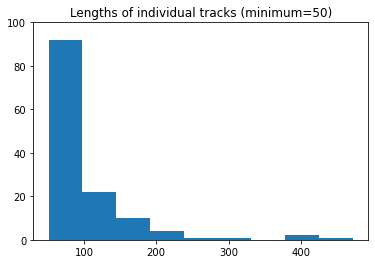

In [16]:
hist_of_tracklet_lens(df_raw)

0       142
1        13
2       132
3        22
4         5
       ... 
2996      2
2997      2
2998      2
2999      2
3000      2
Name: slice_ind, Length: 3001, dtype: int64

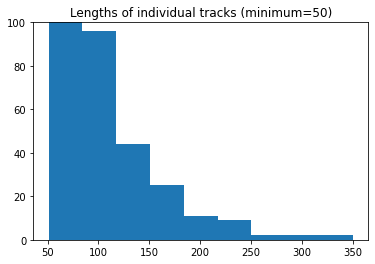

In [17]:
hist_of_tracklet_lens(df_b)

## Better ways to get reference frame neurons

In [134]:
G = build_digraph_from_matches(reference_set.pairwise_matches, reference_set.pairwise_conf, verbose=0)
G = G.to_undirected()

### Modified k-cliques

In [132]:
# Do not remove nodes so we can keep the total clique list
all_cliques = list(nx.find_cliques(G))

In [ ]:
# Loop through decreasing sizes of cliques
# If a clique is found, use it to label neurons
current_global_ind = 0
for k in range(30,7,-1):
    communities = list(k_clique_communities(G, k=k, cliques=all_cliques))
    print(f"Found {len(communities)} communities at k={k}")
    
    for c in communities:
        # First check if labels already exist
        old_labels = set()
        for n in c:
            tmp = G.nodes()[n].get('label', None)
            if tmp is not None:
                old_labels.add(tmp)
        if len(old_labels) > 1:
            print("Found multiple old labels; skipping")
            continue
        elif len(old_labels) == 1:
            current_local_ind = list(old_labels)[0]
            print(f"Found single old label; extending {current_local_ind}")
        else:
            current_local_ind = current_global_ind
            current_global_ind += 1
            print(f"Found no old labels; creating {current_local_ind}")
        for n in c:
            G.nodes()[n]['label'] = current_local_ind
print(f"In total, created {current_global_ind} neuron clusters")

In [124]:
all_sz = defaultdict(int)

for n in G.nodes():
    this_label = G.nodes()[n].get('label', None)
    if this_label is not None:
        all_sz[this_label] += 1

(array([2., 2., 2., 2., 2., 2., 2., 2., 2., 3.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

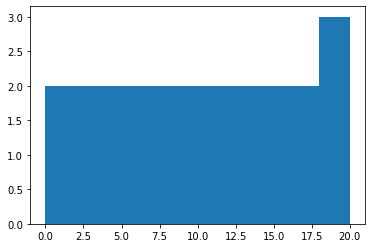

In [125]:
plt.hist(all_sz)

### Sequential

In [4]:
all_matches = reference_set.pairwise_matches
matches_fwd = {k:v for k,v in all_matches.items() if k[1]-k[0]==1}
matches_rev = {k:v for k,v in all_matches.items() if k[0]-k[1]==1}

In [5]:
all_frames = reference_set.reference_frames
df_fwd = build_tracklets_from_classes(all_frames, matches_fwd)
df_rev = build_tracklets_from_classes(all_frames, matches_rev)

Found no matches; is the dictionary in the proper format?


In [12]:
all_len = df_fwd['all_ind_global'].apply(len)
np.unique(all_len, return_counts=True)

(array([2, 3, 4], dtype=int64), array([39, 19, 97], dtype=int64))

# Scratch

### Girvan-newman

In [135]:
from networkx.algorithms import community
#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman

In [137]:
# comp = community.girvan_newman(G)
# tuple(sorted(c) for c in next(comp))

## Details of the reference set

In [51]:
new_matches = convert_labels_to_matches(reference_set.local2global)

In [53]:
plot_three_point_clouds(reference_set.reference_frames, new_matches, 50)

[PointCloud with 164 points.,
 PointCloud with 156 points.,
 LineSet with 24 lines.,
 PointCloud with 164 points.,
 PointCloud with 151 points.,
 LineSet with 33 lines.,
 PointCloud with 156 points.,
 PointCloud with 151 points.,
 LineSet with 30 lines.]

In [166]:
# Reuse the previous reference frames
opt = {'start_frame':50,
       'num_frames':10,
       'num_reference_frames':9,
       'num_slices':33,
       'add_gp_to_candidates':False,
       'add_affine_to_candidates':False,
       'use_affine_matching':False,
       'neuron_cluster_mode':'voronoi',
       'external_detections':external_annotations}
out = track_via_reference_frames(btf_fname_red, **opt, reference_set=reference_set)
all_matches2, all_other_frames2, reference_set2 = out

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.97s/it]


In [57]:
# all_matches2

In [141]:
all_pairs = reference_set.pairwise_matches.keys()
unique_nodes = set(node for pair in all_pairs for node in pair)
unique_nodes

{50, 51, 52}

## Details of a single match

In [7]:
f = all_other_frames[0]
f_bp_matches, f_conf, f_global_matches = match_to_reference_frames(f, reference_set)

In [56]:
# f_global_matches

In [15]:
l2g = dict(f_bp_matches)
g2l = {v:k for k,v in l2g.items()}

In [28]:
l2g[6]

8

# Compare to old method

In [34]:
opt = {'start_frame':51,
       'num_frames':3,
       'verbose':0,
       'num_slices':33,
       #'num_subsequent_matches':1,
       'save_candidate_matches':True,
       'add_affine_to_candidates':False,
       'add_gp_to_candidates':False,
       'external_detections':None}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
# out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches2, all_conf2, all_frames2, candidates2 = out

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.76s/it]


In [35]:
k = (51,52)
plot_matched_point_clouds(all_frames2, all_matches2, k);

## Two point clouds on top of one another

In [67]:
i = 52

# Reflect the x index
zxy = all_frames[i].vol_shape
neuron_locs = all_frames[i].neuron_locs.copy()
neuron_locs = neuron_locs[:, [0,2,1]]
# neuron_locs[:,2] = zxy[2] - neuron_locs[:,2]
pc_new = build_neuron_tree(neuron_locs, False)[1]
pc_new.paint_uniform_color([0,1,0])

pc_old = build_neuron_tree(all_frames2[i].neuron_locs, False)[1]
pc_old.paint_uniform_color([0.5,.5,0.5])

PointCloud with 143 points.

In [68]:
o3d.visualization.draw_geometries([pc_old, pc_new])

In [45]:
neuron_locs

array([369.02657219, 485.58744395, 492.09069212, 475.68562874,
       477.01346154, 571.71272115, 424.84378563, 586.24503311,
       339.58541459, 485.80743494, 403.13101904, 329.23891626,
       558.40498034, 410.16290727, 388.69257951, 389.09010459,
       366.72797527, 472.62327718, 374.51398026, 532.08779631,
       488.11659664, 358.66783831, 282.05089059, 514.98863636,
       502.27384615, 489.82801932, 444.11418048, 379.33460076,
       368.38700291, 372.87755102, 412.64166667, 384.00630631,
       540.5813282 , 399.70223979, 356.25837989, 452.47216495,
       469.0482866 , 456.11661808, 458.65347722, 394.95739015,
       436.34782609, 476.48628193, 462.16389245, 438.00242718,
       485.7029549 , 433.72076372, 442.68024691, 476.25827815,
       464.775     , 281.02160864, 517.23133236, 378.5915493 ,
       448.1641791 , 510.60475162, 331.79354839, 425.6468254 ,
       513.50639135, 479.3653484 , 459.08008214, 450.25336927,
       469.58024691, 487.53658537, 460.11977716, 496.74